In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_absolute_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats

In [113]:
# read data 
montel = pd.read_csv('montel.csv')
entso = pd.read_csv('entso.csv')
weather = pd.read_csv('weather.csv')

# Check data for NaNs and identify useful features

In [114]:
montel_1 = montel.drop(['Time'], axis = 1)
merge_1 = pd.concat([montel_1, weather], axis=1)
df = merge_1.set_index('Time')
df.index = pd.to_datetime(df.index)
df

,Value,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
Time,,,,,,,,,,,,
2012-01-01 00:00:00,25.12,6.4,5.7,95.6,1.8,NaN,260.0,17.3,NaN,1016.9,NaN,NaN
2012-01-01 01:00:00,23.64,6.6,6.0,96.1,2.1,NaN,260.0,14.8,NaN,1017.2,NaN,NaN
2012-01-01 02:00:00,19.03,6.8,6.2,96.1,1.5,NaN,250.0,13.7,NaN,1017.4,NaN,NaN
2012-01-01 03:00:00,15.97,6.9,6.3,96.0,0.6,NaN,250.0,12.6,NaN,1017.4,0.0,NaN
2012-01-01 04:00:00,15.90,7.6,6.6,93.5,0.0,NaN,260.0,14.0,NaN,1017.4,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01 19:00:00,86.70,14.6,5.4,55.1,0.0,NaN,70.0,10.8,24.0,1015.8,58.0,3.0
2021-06-01 20:00:00,85.14,12.4,5.6,63.9,0.0,NaN,80.0,10.4,15.0,1016.2,5.0,1.0
2021-06-01 21:00:00,80.50,11.3,5.2,67.1,0.0,NaN,90.0,10.9,17.0,1016.3,0.0,2.0


In [15]:
print(montel.shape)
print(entso.shape)
print(weather.shape)
entso

(82560, 2)
(57059, 5)
(82560, 12)


,time,Solar_gen,Wind_Onshore_gen,Wind_Offshore_gen,Load
0,2015-01-01 00:00:00+01:00,0.0,8193.25,516.50,51092.00
1,2015-01-01 01:00:00+01:00,0.0,8367.50,516.25,49822.25
2,2015-01-01 02:00:00+01:00,0.0,8604.00,514.00,48072.25
3,2015-01-01 03:00:00+01:00,0.0,8617.00,517.75,46334.25
4,2015-01-01 04:00:00+01:00,0.0,8707.50,519.75,45549.50
...,...,...,...,...,...
57054,2021-07-05 07:00:00+02:00,NaN,NaN,NaN,60065.25
57055,2021-07-05 08:00:00+02:00,NaN,NaN,NaN,62777.50
57056,2021-07-05 09:00:00+02:00,NaN,NaN,NaN,48210.50
57057,2021-07-05 10:00:00+02:00,NaN,NaN,NaN,66325.25


In [39]:
pd.set_option('display.max_rows', 10000)
weather

,Time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2012-01-01 00:00:00,6.4,5.7,95.6,1.8,NaN,260.0,17.3,NaN,1016.9,NaN,NaN
1,2012-01-01 01:00:00,6.6,6.0,96.1,2.1,NaN,260.0,14.8,NaN,1017.2,NaN,NaN
2,2012-01-01 02:00:00,6.8,6.2,96.1,1.5,NaN,250.0,13.7,NaN,1017.4,NaN,NaN
3,2012-01-01 03:00:00,6.9,6.3,96.0,0.6,NaN,250.0,12.6,NaN,1017.4,0.0,NaN
4,2012-01-01 04:00:00,7.6,6.6,93.5,0.0,NaN,260.0,14.0,NaN,1017.4,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
82555,2021-06-01 19:00:00,14.6,5.4,55.1,0.0,NaN,70.0,10.8,24.0,1015.8,58.0,3.0
82556,2021-06-01 20:00:00,12.4,5.6,63.9,0.0,NaN,80.0,10.4,15.0,1016.2,5.0,1.0
82557,2021-06-01 21:00:00,11.3,5.2,67.1,0.0,NaN,90.0,10.9,17.0,1016.3,0.0,2.0
82558,2021-06-01 22:00:00,10.5,4.7,68.7,0.0,NaN,90.0,10.6,15.0,1016.2,0.0,1.0


In [19]:
print("Entso NaNs: {}".format(entso.isnull().sum()))
print("---------------")
print("Weather NaNs: {}".format(weather.isnull().sum()))

Entso NaNs: time                  0
Solar_gen            36
Wind_Onshore_gen     36
Wind_Offshore_gen    36
Load                  0
dtype: int64
---------------
Weather NaNs: Time        0
temp        0
dwpt        0
rhum        0
prcp        0
snow    65198
wdir     4391
wspd     1242
wpgt    53290
pres       24
tsun    13553
coco    53302
dtype: int64


In [24]:
pd.set_option('display.max_rows', 1000)
valuecheck = entso.isnull().sum(axis=1)
print(valuecheck)

0        0
1        0
2        0
3        0
4        0
        ..
57054    3
57055    3
57056    3
57057    3
57058    3
Length: 57059, dtype: int64


In [26]:
drop = np.array([], dtype = int)
for i in range(0, len(valuecheck)):
    if valuecheck[i] > 2:
        drop = np.append(drop,i)
        
print(drop)

[57023 57024 57025 57026 57027 57028 57029 57030 57031 57032 57033 57034
 57035 57036 57037 57038 57039 57040 57041 57042 57043 57044 57045 57046
 57047 57048 57049 57050 57051 57052 57053 57054 57055 57056 57057 57058]


In [33]:
pd.set_option('display.max_rows', 1000)
valuecheck = pd.DataFrame(weather.isnull().sum(axis=1))
print(valuecheck)

       0
0      4
1      4
2      4
3      3
4      3
...   ..
82555  1
82556  1
82557  1
82558  1
82559  1

[82560 rows x 1 columns]


In [29]:
pd.set_option('display.max_rows', 1000)
drop = np.array([], dtype = int)
for i in range(0, len(valuecheck)):
    if valuecheck[i] > 4:
        drop = np.append(drop,i)
        
print(drop)

[17116 17117 17118 ... 50616 50617 50618]


In [96]:
we = weather.set_index('Time')
we.index = pd.to_datetime(we.index)
data_monthly = we.resample('1D').mean()

en = entso.set_index('time')
en.index = pd.to_datetime(en.index)

# Plot the data (use for report)

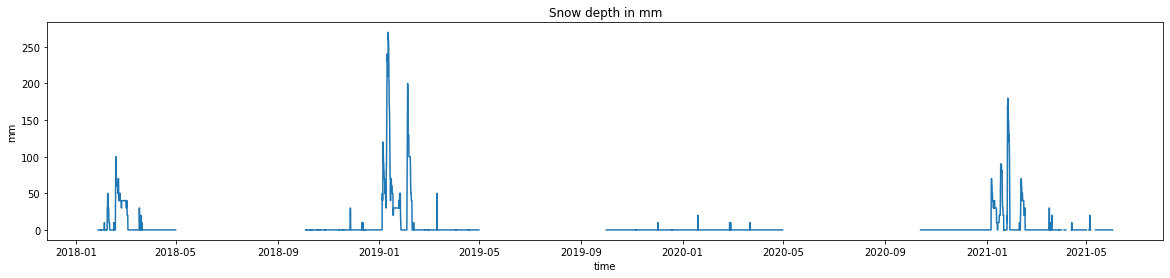

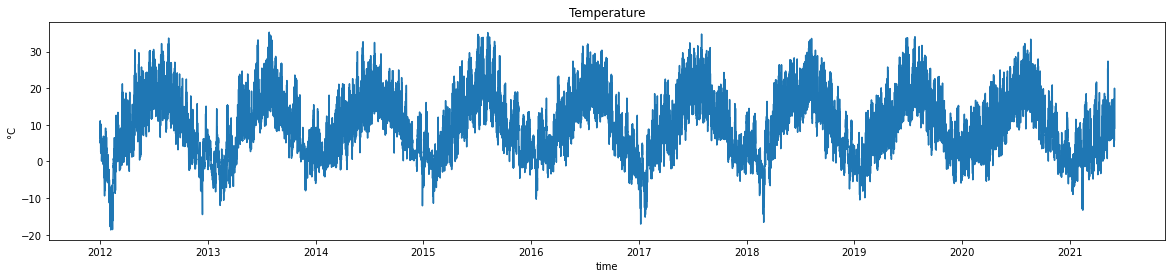

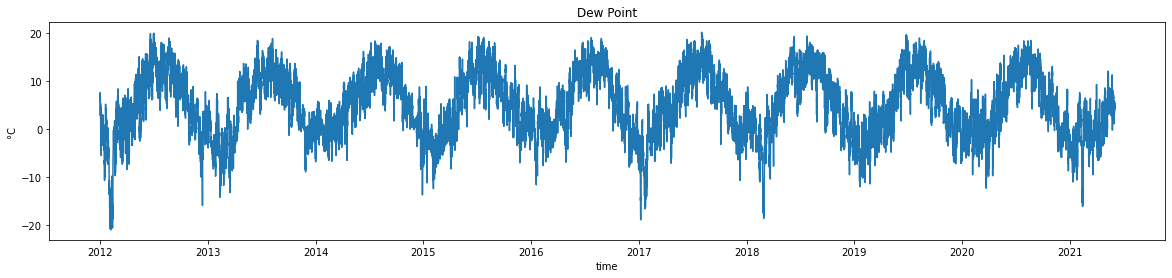

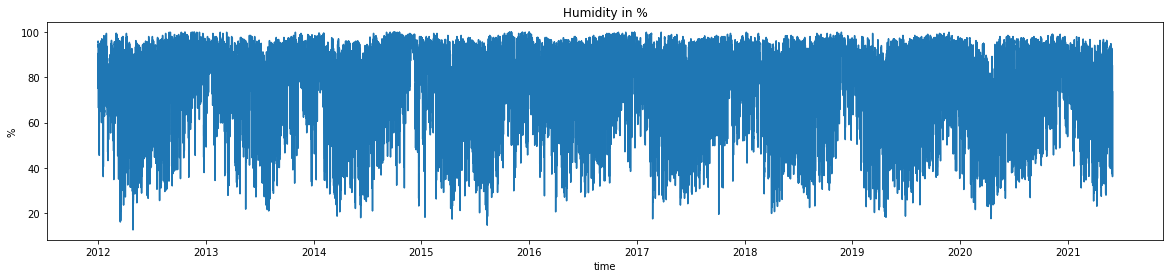

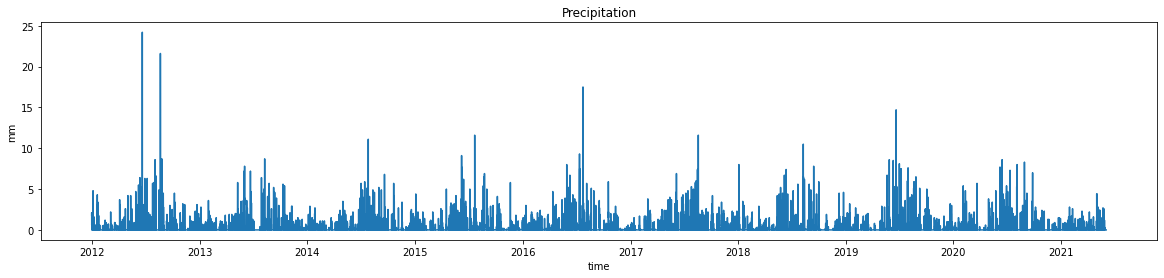

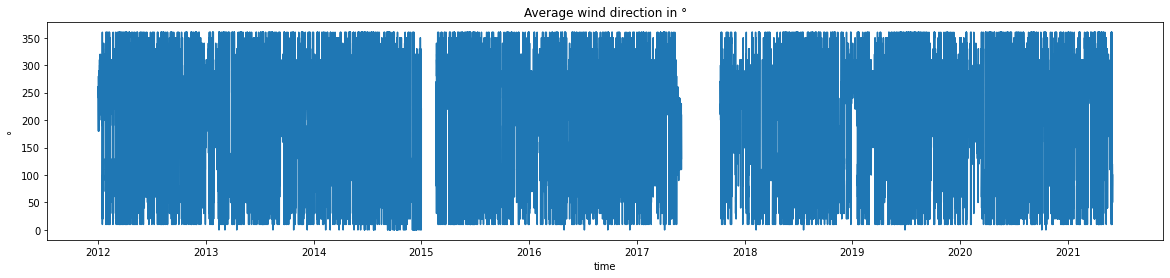

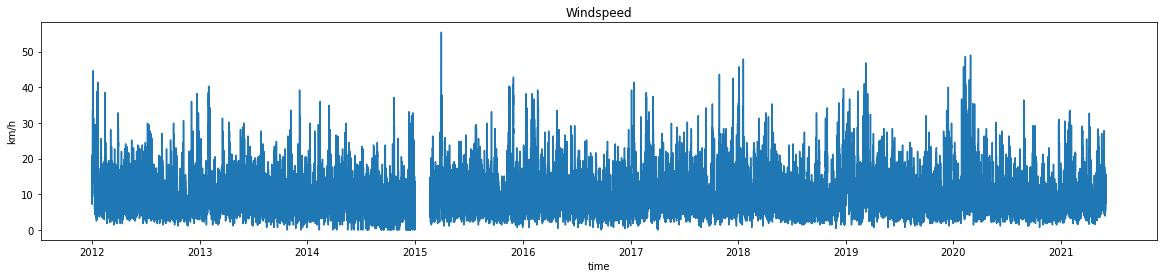

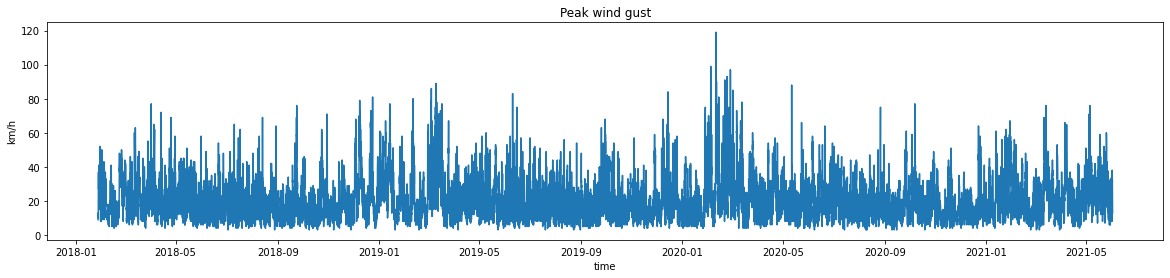

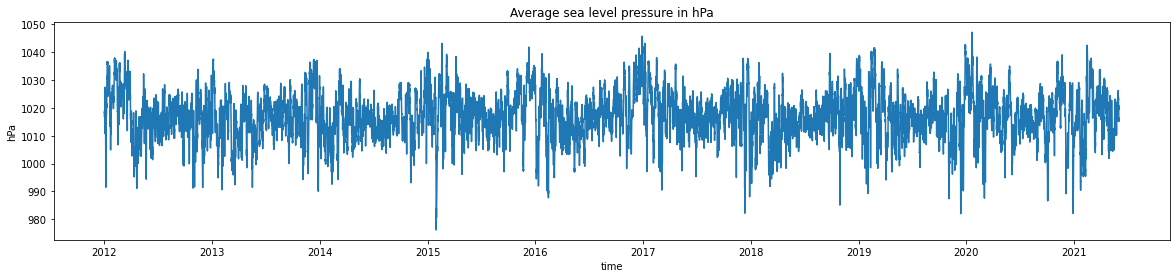

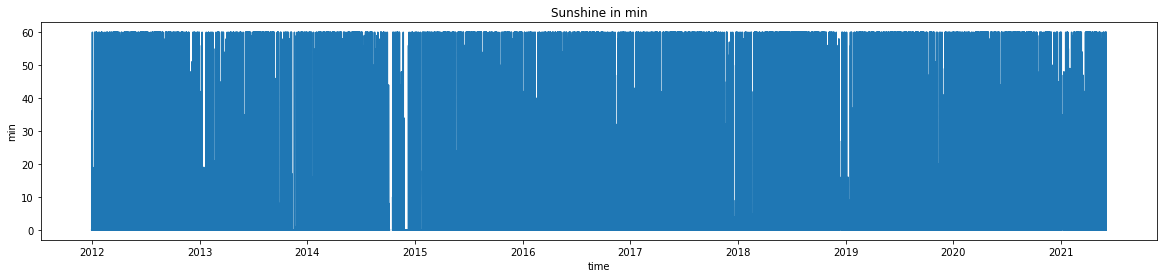

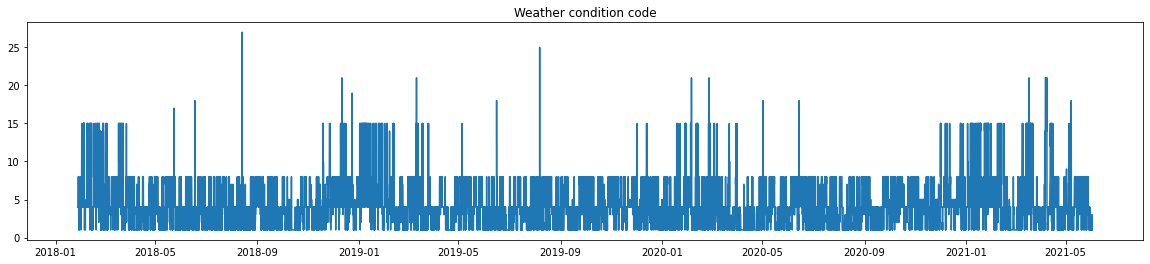

In [139]:
plt.figure(figsize = (20, 4))
plt.plot(we.index, we['snow'])
plt.title('Snow depth in mm')
plt.ylabel('mm')
plt.xlabel('time')
plt.figure(figsize = (20, 4))
plt.plot(we.index, we['temp'])
plt.title('Temperature')
plt.ylabel('°C')
plt.xlabel('time')
#plt.savefig('Temp data')
plt.figure(figsize = (20, 4))
plt.plot(we.index, we['dwpt'])
plt.title('Dew Point')
plt.ylabel('°C')
plt.xlabel('time')
#plt.savefig('Dew data')
plt.figure(figsize = (20, 4))
plt.plot(we.index, we['rhum'])
plt.title('Humidity in %')
plt.ylabel('%')
plt.xlabel('time')
#plt.savefig('Hum data')
plt.figure(figsize = (20, 4))
plt.plot(we.index, we['prcp'])
plt.title('Precipitation')
plt.ylabel('mm')
plt.xlabel('time')
#plt.savefig('Pre data')
plt.figure(figsize = (20, 4))
plt.plot(we.index, we['wdir'])
plt.title('Average wind direction in °')
plt.ylabel('°')
plt.xlabel('time')
#plt.savefig('Winddir data')
plt.figure(figsize = (20, 4))
plt.plot(we.index, we['wspd'])
plt.title('Windspeed')
plt.ylabel('km/h')
plt.xlabel('time')
#plt.savefig('Windspeed data')
plt.figure(figsize = (20, 4))
plt.plot(we.index, we['wpgt'])
plt.title('Peak wind gust')
plt.ylabel('km/h')
plt.xlabel('time')
#plt.savefig('Peak wind gust data')
plt.figure(figsize = (20, 4))
plt.plot(we.index, we['pres'])
plt.title('Average sea level pressure in hPa')
plt.ylabel('hPa')
plt.xlabel('time')
#plt.savefig('Sea level gust data')
plt.figure(figsize = (20, 4))
plt.plot(we.index, we['tsun'])
plt.title('Sunshine in min')
plt.ylabel('min')
plt.xlabel('time')
#plt.savefig('Sunshine data')
plt.figure(figsize = (20, 4))
plt.plot(we.index, we['coco'])
plt.title('Weather condition code')
#plt.savefig('Weather code data')


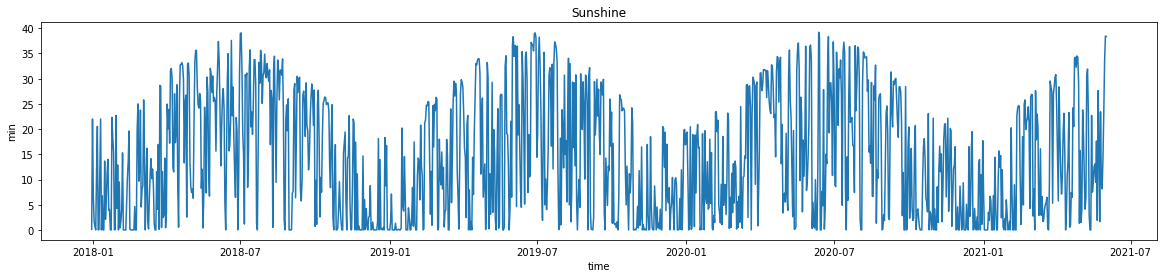

In [147]:
plt.figure(figsize = (20, 4))
plt.plot(data_monthly.index[2190:], data_monthly['tsun'][2190:])
plt.title('Sunshine')
plt.ylabel('min')
plt.xlabel('time')
#plt.savefig('sunshine ab 2018')

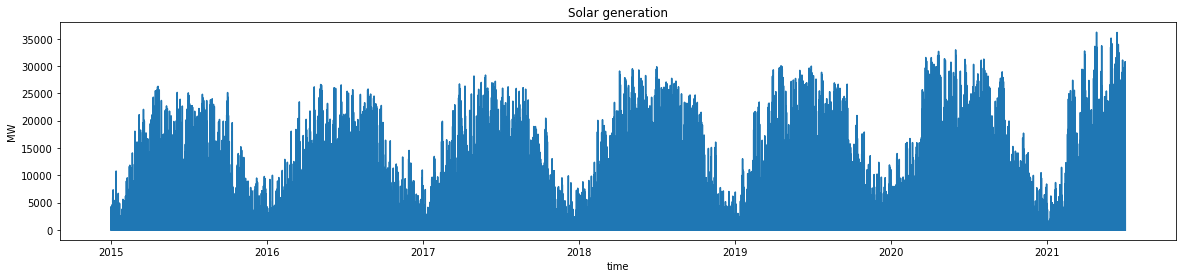

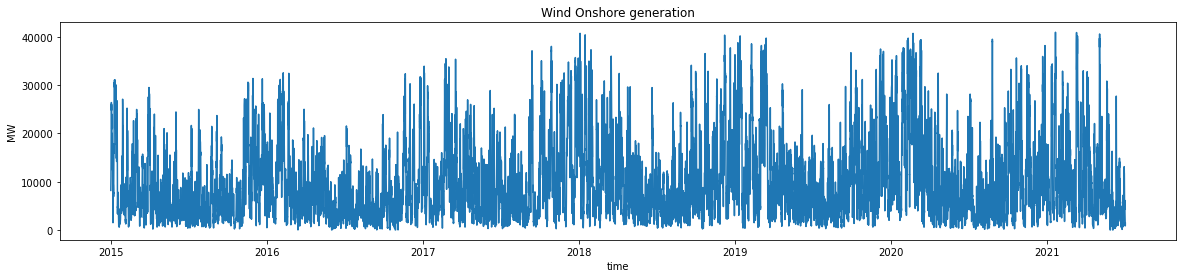

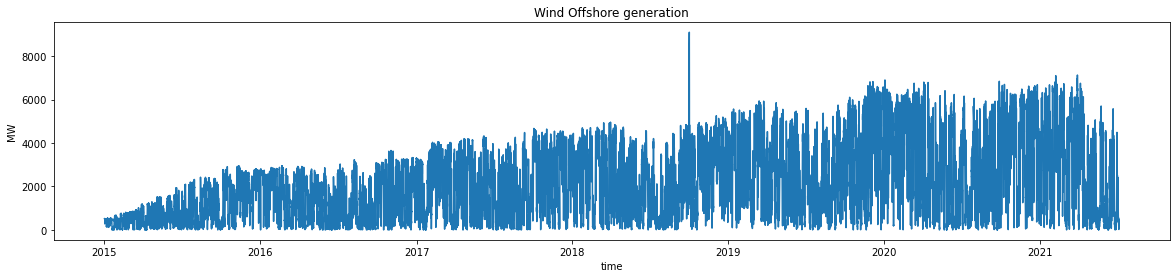

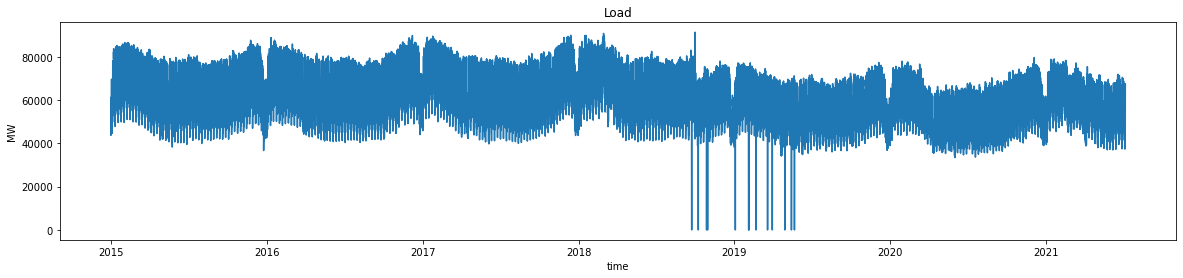

In [150]:
plt.figure(figsize = (20, 4))
plt.plot(en.index, en['Solar_gen'])
plt.title('Solar generation')
plt.ylabel('MW')
plt.xlabel('time')
#plt.savefig('Solar data')
plt.figure(figsize = (20, 4))
plt.plot(en.index, en['Wind_Onshore_gen'])
plt.title('Wind Onshore generation')
plt.ylabel('MW')
plt.xlabel('time')
#plt.savefig('Wind Onshore generation data')
plt.figure(figsize = (20, 4))
plt.plot(en.index, en['Wind_Offshore_gen'])
plt.title('Wind Offshore generation')
plt.ylabel('MW')
plt.xlabel('time')
#plt.savefig('Wind Offshore generation data')
plt.figure(figsize = (20, 4))
plt.plot(en.index, en['Load'])
plt.title('Load')
plt.ylabel('MW')
plt.xlabel('time')
#plt.savefig('Load data')

# Check for correlations

Pandas computed Pearson r:           Value      temp      dwpt      rhum      prcp      snow      wdir  \
Value  1.000000 -0.113405 -0.072513  0.098194 -0.009225  0.126946 -0.071031   
temp  -0.113405  1.000000  0.853654 -0.562779  0.007258 -0.291271  0.026223   
dwpt  -0.072513  0.853654  1.000000 -0.060627  0.120321 -0.273576  0.063884   
rhum   0.098194 -0.562779 -0.060627  1.000000  0.194457  0.113609  0.035897   
prcp  -0.009225  0.007258  0.120321  0.194457  1.000000  0.072155  0.129647   
snow   0.126946 -0.291271 -0.273576  0.113609  0.072155  1.000000  0.063504   
wdir  -0.071031  0.026223  0.063884  0.035897  0.129647  0.063504  1.000000   
wspd  -0.168048  0.041080 -0.099156 -0.263858  0.128499  0.083340  0.183834   
wpgt  -0.215442  0.053939 -0.111618 -0.299832  0.166550  0.056884  0.198846   
pres   0.063267 -0.239566 -0.217501  0.114009 -0.092626  0.085709 -0.028516   
tsun  -0.063738  0.485230  0.151166 -0.684141 -0.145402 -0.072867 -0.127820   
coco   0.095206 -0.263679

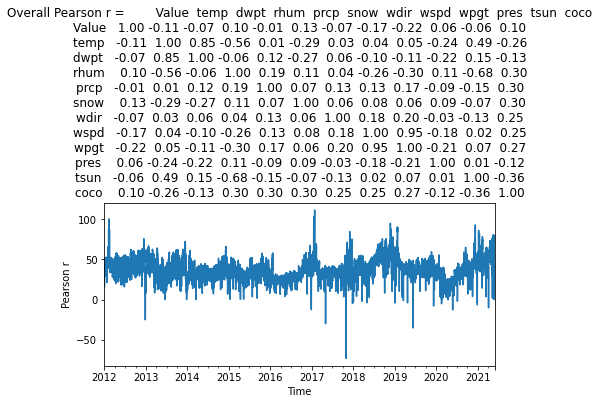

In [133]:
overall_pearson_r = df.corr()
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943

r, p = stats.pearsonr(df.dropna()['Value'], df.dropna()['snow'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
df['Value'].rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");